## Luminaire
**Table of Contents**
* Section 1: Data Exploration
    * Section 1.1: Change point detection
    * Section 1.2: Stock time series with default setting
    * Section 1.3: Plot the change points and the trendlines
    * Section 1.4: With log transformation: is_log_transformed = True
    * Section 1.4: Bike share data
* Section 2: Config Optimization
* Section 3: Modeling
    * Section 3.1: The structural model
    * Section 3.2: The Kalman Filter model

### Section 1: Data Exploration
* **API** - https://zillow.github.io/luminaire/api_reference/exploration.html
* **freq (str)** – The frequency of the time-series. A Pandas offset such as ‘D’, ‘H’, or ‘M’. Luminaire currently supports the following pandas frequency types: ‘H’, ‘D’, ‘W’, ‘W-SUN’, ‘W-MON’, ‘W-TUE’, ‘W-WED’, ‘W-THU’, ‘W-FRI’, ‘W-SAT’.
* **sig_level (float)** – The significance level to use for any statistical test withing data profile. This should be a number between 0 and 1.
* **min_ts_mean (float)** – The minimum mean value of the time series required for the model to run. For data that originated as integers (such as counts), the ARIMA model can behave erratically when the numbers are small. When this parameter is set, any time series whose mean value is less than this will automatically result in a model failure, rather than a mostly bogus anomaly.
* **fill_rate (float)** – Minimum proportion of data availability in the recent data window. Should be a fraction between 0 and 1.
* **max_window_length (int)** – The maximum size of the sub windows for input data segmentation.
* **window_length (int)** – The size of the sub windows for input data segmentation.
* **min_ts_length (int)** – The minimum required length of the time series for training.
* **max_ts_length (int)** – The maximum required length of the time series for training.
* **is_log_transformed (bool)** – A flag to specify whether to take a log transform of the input data. If the data contain negatives, is_log_transformed is ignored even though it is set to True.
* **data_shift_truncate (bool)** – A flag to specify whether left side of the most recent change point needs to be truncated from the training data.
* **min_changepoint_padding_length (int)** – A padding length between two change points. This parameter makes sure that two consecutive change points are not close to each other.
* **change_point_threshold (float)** – Minimum threshold (a value > 0) to flag change points based on KL divergence. This parameter can be used to tune the sensitivity of the change point detection method.
* Class - https://github.com/zillow/luminaire/blob/master/luminaire/exploration/data_exploration.py

### Section 1.1: Change point detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

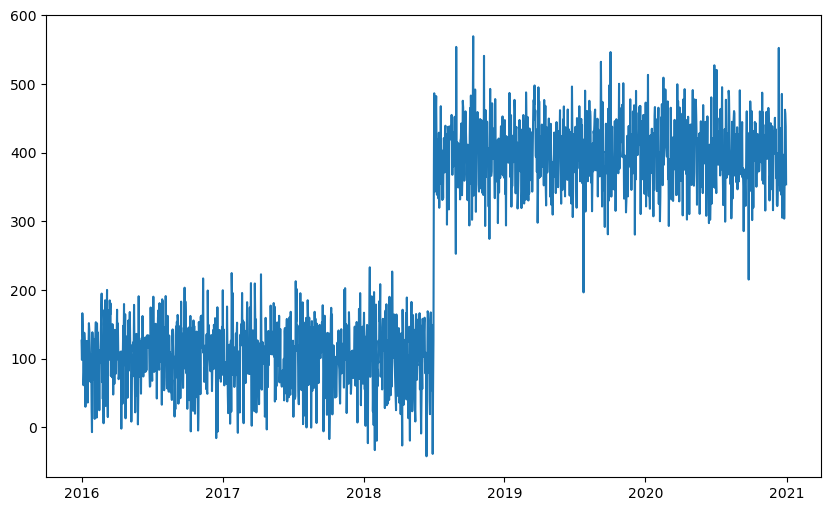

In [2]:
time_idx = pd.date_range(start='2016-01-01',end='2020-12-31',freq='D')
mu1 = 100
sigma1 = 50
mu2 = 400
sigma2 = 50
seg_len1 = int(len(time_idx)/2)
seg_len2 = len(time_idx) - seg_len1
ts = np.concatenate([np.random.normal(mu1,sigma1,seg_len1),np.random.normal(mu2,sigma2,seg_len2)])
ts = pd.DataFrame({'index':time_idx,'raw':ts}) # Should be called 'raw'
ts = ts.set_index('index')
plt.figure(figsize=(10,6))
plt.plot(ts['raw'])

In [3]:
#pip install luminaire
import luminaire
from luminaire.model.window_density import WindowDensityHyperParams, WindowDensityModel
from luminaire.exploration.data_exploration import DataExploration

In [4]:
# Without log transformation: is_log_transformed = False (Default)
config = WindowDensityHyperParams().params
de = DataExploration(freq='D',
                     data_shift_truncate=True,
                     is_log_transformed=False,
                     fill_rate=0.1                     
                    )
ts2, profile_summary = de.profile(df=ts)  # the model only accepts a time series with the column name 'raw'
ts2

,raw,interpolated
2018-07-02,363.794587,363.794587
2018-07-03,486.509910,486.509910
2018-07-04,343.020657,343.020657
2018-07-05,451.285164,451.285164
2018-07-06,365.064551,365.064551
...,...,...
2020-12-26,303.925825,303.925825
2020-12-27,351.494767,351.494767
2020-12-28,462.546834,462.546834
2020-12-29,456.729891,456.729891


In [5]:
print(ts.shape, ts2.shape)
print(profile_summary)

(1827, 1) (913, 2)
{'success': True, 'trend_change_list': ['2018-05-01 00:00:00', '2018-06-26 00:00:00', '2018-07-10 00:00:00', '2018-09-04 00:00:00'], 'change_point_list': ['2018-07-02 00:00:00'], 'is_log_transformed': False, 'min_ts_mean': None, 'ts_start': '2018-01-02 00:00:00', 'ts_end': '2020-12-30 00:00:00'}


In [11]:
change_point_list = list(pd.to_datetime(profile_summary['change_point_list']))
trend_change_list = list(pd.to_datetime(profile_summary['trend_change_list']))

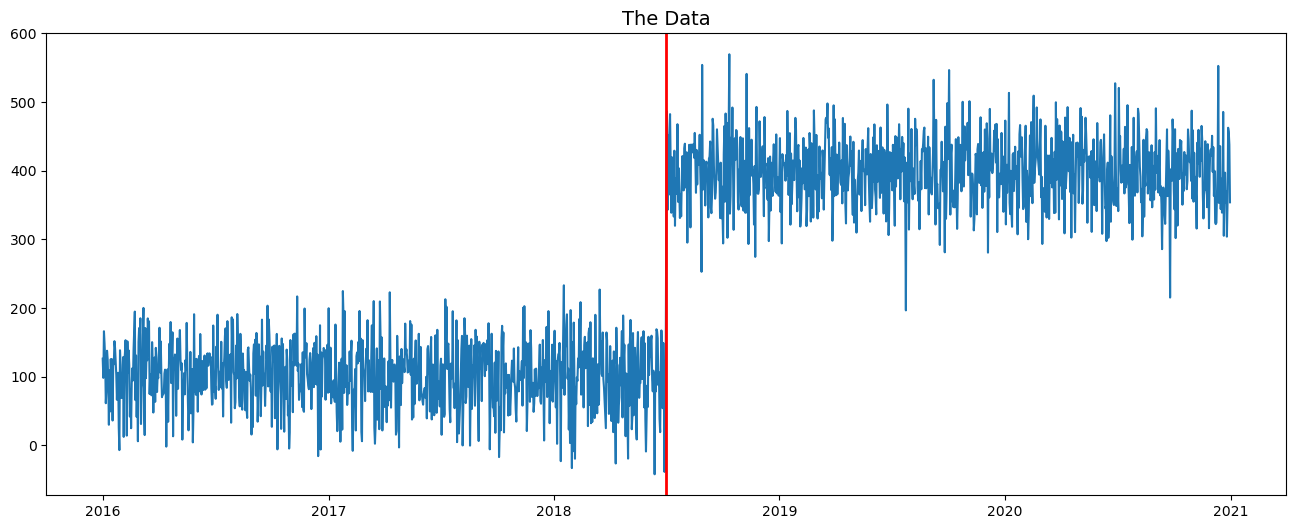

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16,6))
plt.plot(ts['raw'], linestyle = '-')
plt.title('The Data',fontsize=14)

for x in change_point_list:
    plt.axvline(x,lw=2, color='red')

plt.show()
#plt.savefig("percentile_plot.png")
#plt.close()

### Section 1.2: Stock time series with default setting

[*********************100%***********************]  1 of 1 completed


,raw
Date,
2018-01-02,247.899826
2018-01-03,249.467789
2018-01-04,250.519302
2018-01-05,252.188751
2018-01-08,252.649918


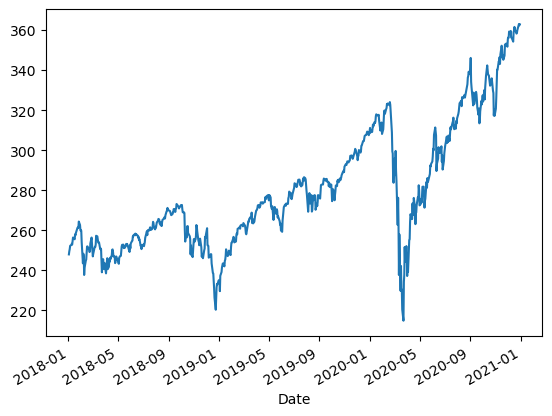

In [14]:
#! pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
spy = yf.download("SPY", start="2018-01-01", end="2020-12-31")
spy['Adj Close'].plot()
data = pd.DataFrame({'raw': spy['Adj Close']})
data.head()

In [15]:
# Without log transformation: is_log_transformed = False (Default)
config = WindowDensityHyperParams().params
de = DataExploration(freq='D',
                 fill_rate=0.1
                    )
data2, profile_summary = de.profile(df=data)
print("The input data:" , data.shape)
print("The output data:" , data2.shape)
print(profile_summary)
data2.head()

The input data: (755, 1)
The output data: (56, 2)
{'success': True, 'trend_change_list': ['2018-04-03 00:00:00', '2018-04-24 00:00:00', '2018-08-07 00:00:00', '2018-10-23 00:00:00', '2018-11-20 00:00:00', '2019-02-05 00:00:00', '2019-03-05 00:00:00', '2019-04-09 00:00:00', '2019-05-21 00:00:00', '2019-07-30 00:00:00', '2019-08-20 00:00:00', '2019-10-22 00:00:00', '2019-12-24 00:00:00', '2020-02-18 00:00:00', '2020-03-03 00:00:00', '2020-05-05 00:00:00', '2020-05-26 00:00:00', '2020-07-21 00:00:00', '2020-09-08 00:00:00', '2020-10-13 00:00:00'], 'change_point_list': ['2018-07-09 00:00:00', '2018-08-24 00:00:00', '2018-10-10 00:00:00', '2019-02-03 00:00:00', '2019-04-04 00:00:00', '2019-06-18 00:00:00', '2019-10-25 00:00:00', '2020-02-27 00:00:00', '2020-04-08 00:00:00', '2020-05-27 00:00:00', '2020-11-05 00:00:00'], 'is_log_transformed': None, 'min_ts_mean': None, 'ts_start': '2018-01-02 00:00:00', 'ts_end': '2020-12-30 00:00:00'}


,raw,interpolated
2020-11-05,340.226532,340.226532
2020-11-06,340.148804,340.148804
2020-11-07,NaN,340.443203
2020-11-08,NaN,341.894685
2020-11-09,344.423004,344.423004


### Section 1.3 Plot the change points and the trendlines

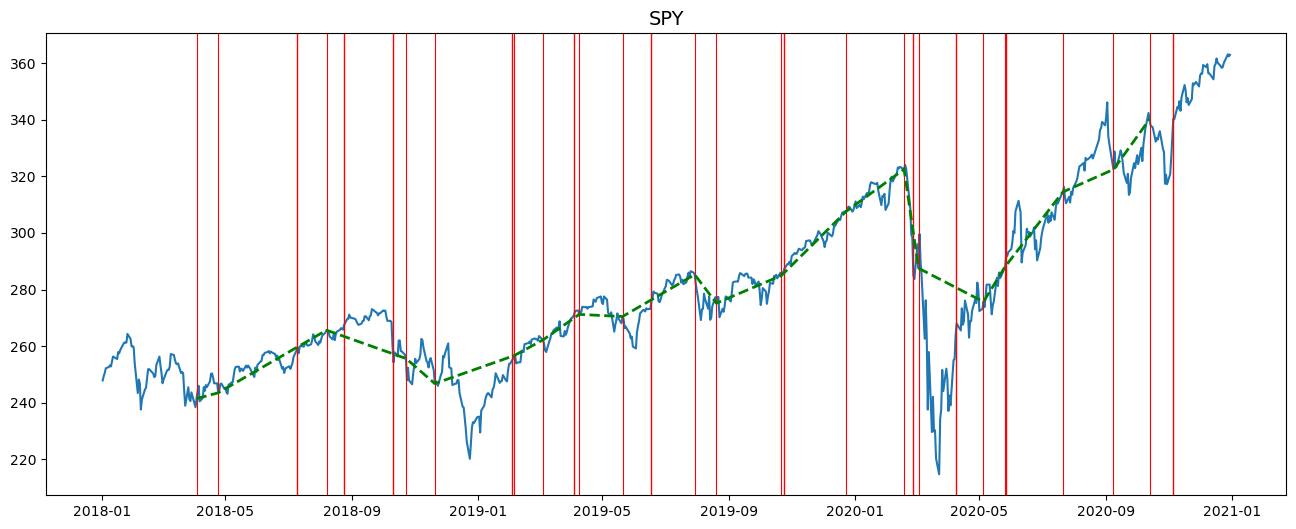

In [17]:
# Collect the trend change dates in a list
# Collect the change points in a list
change_point_list = list(pd.to_datetime(profile_summary['change_point_list']))
trend_change_list = list(pd.to_datetime(profile_summary['trend_change_list']))
trendline = data[data.index.isin(trend_change_list)]

plt.figure(figsize=(16,6))
plt.plot(data['raw'], linestyle = '-')
plt.title('SPY',fontsize=14)

# Plot the trends
for x in trend_change_list:
    plt.axvline(x,lw=0.8, color='red')

# Plot the change points
for x in change_point_list:
    plt.axvline(x,lw=1, color='red')
    
plt.plot(trendline,lw=2, linestyle='dashed', color = 'green')
plt.show()
#plt.savefig("percentile_plot.png")
#plt.close()

### Section 1.4 With log transformation: is_log_transformed = True

In [18]:
# Without log transformation: is_log_transformed = False (Default)
config = WindowDensityHyperParams().params
de = DataExploration(freq='D',
                 fill_rate=0.01,
                 is_log_transformed = True
                    )
data2, process_summary = de.profile(df=data)  #stream_profile(df=data)
trend_change_list = list(process_summary['trend_change_list'])
data2.head()

,raw,interpolated
2020-11-05,340.226532,5.832547
2020-11-06,340.148804,5.832319
2020-11-07,NaN,5.833181
2020-11-08,NaN,5.837423
2020-11-09,344.423004,5.844770


In [19]:
trend_change_list

['2018-04-03 00:00:00',
 '2018-04-24 00:00:00',
 '2018-08-07 00:00:00',
 '2018-10-23 00:00:00',
 '2018-11-20 00:00:00',
 '2019-02-05 00:00:00',
 '2019-03-05 00:00:00',
 '2019-04-09 00:00:00',
 '2019-05-21 00:00:00',
 '2019-07-30 00:00:00',
 '2019-08-20 00:00:00',
 '2019-10-22 00:00:00',
 '2019-12-24 00:00:00',
 '2020-02-18 00:00:00',
 '2020-03-03 00:00:00',
 '2020-05-05 00:00:00',
 '2020-05-26 00:00:00',
 '2020-07-21 00:00:00',
 '2020-09-08 00:00:00',
 '2020-10-13 00:00:00']

* It interpolates the missing data according to the date
* It keeps the minimum 

kf_naive_outlier_detection(input_series, idx_position)[source]¶
This function detects outlier for the specified index position of the series.

In [20]:
de.kf_naive_outlier_detection(data['raw'],72)


False

### Section 1.5 Bike share data

In [27]:
bike = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike-sharing-daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['dteday','raw']
bike['dteday'] = pd.to_datetime(bike['dteday'], format='%Y-%m-%d')
bike.index = bike['dteday']
bike = bike.drop('dteday',axis=1)
bike

,raw
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


In [28]:
# Without log transformation: is_log_transformed = False (Default)
de = DataExploration(freq='D',
                 fill_rate=0.01,
                # is_log_transformed = True
                    )
bike2, profile = de.profile(df=bike)  
#trend_change_list = list(process_summary['trend_change_list'])
bike2.head()

,raw,interpolated
2011-04-23,4036.0,4036.0
2011-04-24,4191.0,4191.0
2011-04-25,4073.0,4073.0
2011-04-26,4400.0,4400.0
2011-04-27,3872.0,3872.0


### Section 2 Config Optimization
* Auto-selection of the best data preprocessing configuration and the outlier detection model training configuration with respect to the input time series. 
* This option enables Luminaire to work as a hands-off system where the user only has to provide the input data along with its frequency. 
* This option should be used if the user wants avoid any manual configuration and should be called prior to the data pre-processing and training steps.
* API: https://zillow.github.io/luminaire/api_reference/optimization.html
* https://github.com/zillow/luminaire/blob/master/luminaire/optimization/hyperparameter_optimization.py

#### Section 2.1 Bike share data

In [30]:
from luminaire.optimization.hyperparameter_optimization import HyperparameterOptimization
op = HyperparameterOptimization(freq='D')
optimz = op.run(data=bike)
print(optimz)

100%|██████████| 50/50 [02:05<00:00,  2.50s/trial, best loss: 0.706189491473236] 
{'LuminaireModel': 'LADFilteringModel', 'data_shift_truncate': 1, 'fill_rate': 0.9528218172856562, 'is_log_transformed': 0}


In [31]:
from luminaire.exploration.data_exploration import DataExploration
de_optimz = DataExploration(freq='D', **optimz)
bike2, bike_pre_prc = de_optimz.profile(bike)
print(bike2)

               raw  interpolated
2011-04-23  4036.0        4036.0
2011-04-24  4191.0        4191.0
2011-04-25  4073.0        4073.0
2011-04-26  4400.0        4400.0
2011-04-27  3872.0        3872.0
...            ...           ...
2012-12-27  2114.0        2114.0
2012-12-28  3095.0        3095.0
2012-12-29  1341.0        1341.0
2012-12-30  1796.0        1796.0
2012-12-31  2729.0        2729.0

[619 rows x 2 columns]


In [38]:
bike_trend_change_list = list(pd.to_datetime(bike_pre_prc['trend_change_list']))
bike_change_point_list = list(pd.to_datetime(bike_pre_prc['change_point_list']))
bike_trendline = bike[bike.index.isin(bike_trend_change_list)]
bike_trend_change_list

[Timestamp('2011-03-12 00:00:00'),
 Timestamp('2011-05-07 00:00:00'),
 Timestamp('2011-07-16 00:00:00'),
 Timestamp('2011-10-01 00:00:00'),
 Timestamp('2011-11-19 00:00:00'),
 Timestamp('2012-02-11 00:00:00'),
 Timestamp('2012-03-24 00:00:00'),
 Timestamp('2012-04-14 00:00:00'),
 Timestamp('2012-09-15 00:00:00'),
 Timestamp('2012-10-20 00:00:00'),
 Timestamp('2012-12-08 00:00:00')]

In [39]:
bike_change_point_list

[Timestamp('2011-04-23 00:00:00')]

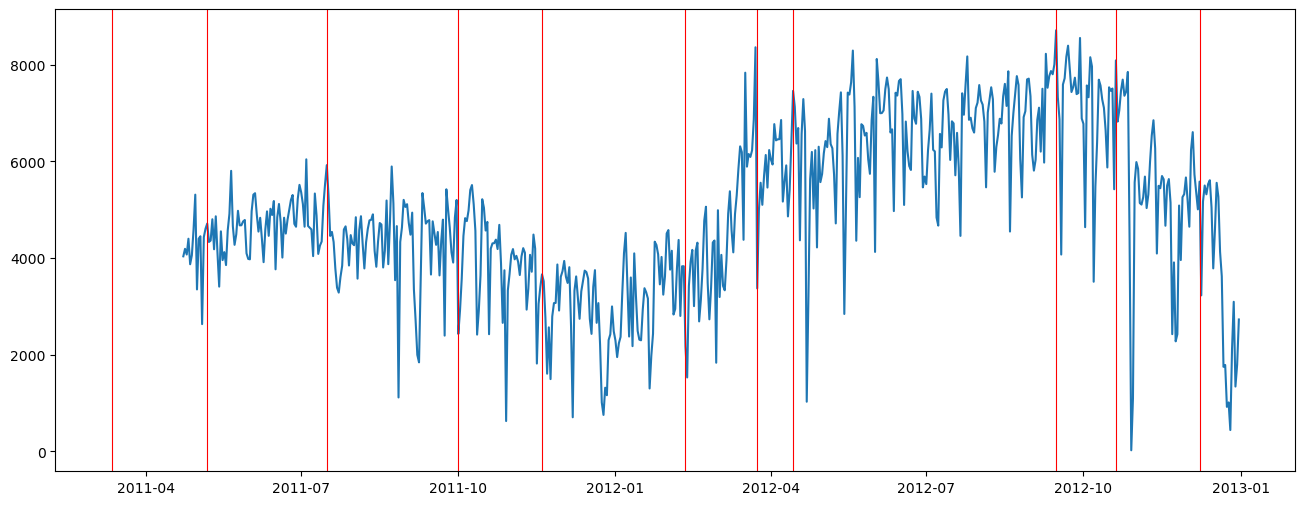

In [40]:
change_point_plot(bike2, bike_trend_change_list)

In [41]:
print(bike.shape, bike2.shape)
print("Bike minimum date: ", bike.index.min(), "Bike2 minimum date: ", bike2.index.min())
print("Bike maximum date: ", bike.index.max(), "Bike2 maximum date: ", bike2.index.max())

(731, 1) (619, 2)
Bike minimum date:  2011-01-01 00:00:00 Bike2 minimum date:  2011-04-23 00:00:00
Bike maximum date:  2012-12-31 00:00:00 Bike2 maximum date:  2012-12-31 00:00:00


* The above optimized configuration contains all the parameters required for data pre-processing and training
* It can be used downstream for performing the data pre-processing and training.
* The code below makes the data ready to be ingested for training. The only step left before training is to extract the luminaire outlier detection model object for the optimized configuration.

In [42]:
bike_model_class_name = optimz['LuminaireModel']
bike_module = __import__('luminaire.model', fromlist=[''])
bike_model_class = getattr(bike_module, bike_model_class_name)
print(bike_model_class)

<class 'luminaire.model.lad_filtering.LADFilteringModel'>


In [43]:
# Let's train the model using the optimal specifications
bike_model_object = bike_model_class(hyper_params=optimz, freq='D')
bike_success, bike_model_date, bike_trained_model = bike_model_object.train(data=bike2, **bike_pre_prc)
print(bike_success, bike_model_date, bike_trained_model)

# Test if the value were 2000 in 2012-6-08 an outlier or not
bike_trained_model.score(2000, '2012-06-08')

True 2012-12-31 00:00:00 <luminaire.model.lad_filtering.LADFilteringModel object at 0x7fedf7212f70>


({'Success': True,
  'AdjustedActual': -1662.0,
  'ConfLevel': 90.0,
  'Prediction': 2476.572619584096,
  'PredStdErr': 627.6155805339104,
  'IsAnomaly': False,
  'IsAnomalyExtreme': False,
  'AnomalyProbability': 0.5607935098933141,
  'DownAnomalyProbability': 0.7803967549466571,
  'UpAnomalyProbability': 0.219603245053343,
  'NonStationarityDiffOrder': 1,
  'ModelFreshness': -20.6},
 <luminaire.model.lad_filtering.LADFilteringModel at 0x7fedf7163880>)

### Section 3 Modeling
#### Section 3.1 Kalman Filter Model
* API: https://zillow.github.io/luminaire/api_reference/batch_models.html#module-luminaire.model.model_utils
* https://zillow.github.io/luminaire/tutorial/outlier_batch.html


In [44]:
# API: https://zillow.github.io/luminaire/api_reference/batch_models.html#module-luminaire.model.model_utils
# https://zillow.github.io/luminaire/tutorial/outlier_batch.html
# Without log transformation: is_log_transformed = False (Default)
de = DataExploration(freq='D',
                 fill_rate=0.1,
                 is_log_transformed = True
                    )
bike2, pre_prc = de.profile(df=bike)  

In [45]:
from luminaire.model.lad_filtering import LADFilteringModel
hyper_params = {"is_log_transformed": 0}
lad_filter_obj = LADFilteringModel(hyper_params=hyper_params, freq='D')
print(lad_filter_obj)
success, model_date, model = lad_filter_obj.train(data=bike2, **pre_prc)
print(success, model_date, model)

True 2012-12-31 00:00:00 <luminaire.model.lad_filtering.LADFilteringModel object at 0x7fedf71b59d0>


In [46]:
# Test if the value were 2000 in 2012-6-08 an outlier or not
model.score(2000, '2012-06-08')

({'Success': True,
  'AdjustedActual': -0.5175304914865355,
  'ConfLevel': 90.0,
  'Prediction': 2387.718712243808,
  'PredStdErr': 735.4123249948354,
  'IsAnomaly': False,
  'IsAnomalyExtreme': False,
  'AnomalyProbability': 0.897174478745516,
  'DownAnomalyProbability': 0.948587239372758,
  'UpAnomalyProbability': 0.05141276062724194,
  'NonStationarityDiffOrder': 1,
  'ModelFreshness': -20.6},
 <luminaire.model.lad_filtering.LADFilteringModel at 0x7fedf7071ac0>)

In [47]:
output_pred = pd.DataFrame()
for i in bike.index:
    actual = bike.loc[i,'raw']
    output = model.score(actual, i)
    tmp = pd.DataFrame.from_dict(output[0], orient='index').T
    tmp['Actual'] = actual
    output_pred = output_pred.append(tmp)  

output_pred['Prediction'] = output_pred['Prediction'].astype(float)
output_pred['PredStdErr'] = output_pred['PredStdErr'].astype(float)    
output_pred['Upper'] = output_pred['Prediction'] + 3 * output_pred['PredStdErr'] 
output_pred['Lower'] = output_pred['Prediction'] - 3 * output_pred['PredStdErr'] 
output_pred[output_pred['IsAnomaly']==True]
output_pred.index = bike.index
# https://www.jmp.com/support/help/en/16.0/index.shtml#page/jmp/standard-error-of-prediction-and-confidence-limits.shtml

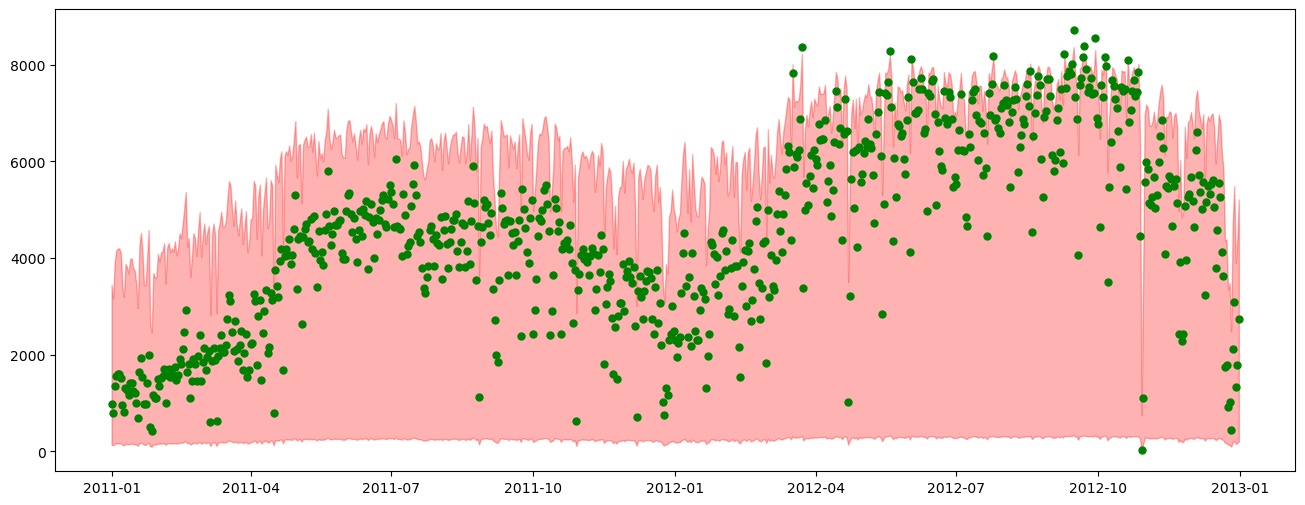

In [48]:
def plot_it(output_pred):
    plt.figure(figsize=(16,6))
    plt.plot(output_pred['Actual'],'go',markersize=5,label='Actual')
    plt.fill_between(
       output_pred.index, output_pred['Lower'], output_pred['Upper'], alpha=0.3, color="red",
       label="Predicted interval")
    plt.show()
    
plot_it(output_pred)


#### Section 3.2 Structural model
* API: https://zillow.github.io/luminaire/api_reference/batch_models.html
* https://zillow.github.io/luminaire/tutorial/outlier_batch.html

In [49]:
from luminaire.exploration.data_exploration import DataExploration
de_obj = DataExploration(freq='D', 
                         fill_rate=0.1)
bike2, pre_prc = de_obj.profile(bike)
print(pre_prc)

{'success': True, 'trend_change_list': ['2011-03-12 00:00:00', '2011-05-07 00:00:00', '2011-07-16 00:00:00', '2011-10-01 00:00:00', '2011-11-19 00:00:00', '2012-02-11 00:00:00', '2012-03-24 00:00:00', '2012-04-14 00:00:00', '2012-09-15 00:00:00', '2012-10-20 00:00:00', '2012-12-08 00:00:00'], 'change_point_list': ['2011-04-23 00:00:00'], 'is_log_transformed': None, 'min_ts_mean': None, 'ts_start': '2011-01-01 00:00:00', 'ts_end': '2012-12-31 00:00:00'}


In [50]:
print(bike.shape, bike2.shape)

(731, 1) (619, 2)


In [51]:
from luminaire.model.lad_structural import LADStructuralModel
hyper_params = {"include_holidays_exog": False, "is_log_transformed": True, "max_ft_freq": 5, "p": 3, "q": 3}
lad_struct_obj = LADStructuralModel(hyper_params=hyper_params, freq='D') 
print(lad_struct_obj)

In [66]:
success, model_date, model = lad_struct_obj.train(data=bike2, **bike_pre_prc)
print(success, model_date, model)

True 2012-12-31 00:00:00 <luminaire.model.lad_structural.LADStructuralModel object at 0x7fedf71eea30>


In [74]:
model.score(2000 ,pd.to_datetime('2013-01-01'))

{'Success': True,
 'IsLogTransformed': 0,
 'AdjustedActual': 2000,
 'Prediction': 2778.776434697092,
 'StdErr': 951.9624952202597,
 'CILower': 1212.9374717122744,
 'CIUpper': 4344.61539768191,
 'ConfLevel': 90.0,
 'ExogenousHolidays': 0,
 'IsAnomaly': False,
 'IsAnomalyExtreme': False,
 'AnomalyProbability': 0.5866854668687971,
 'DownAnomalyProbability': 0.7933427334343985,
 'UpAnomalyProbability': 0.20665726656560152,
 'ModelFreshness': 0.1}

In [64]:
bike2

,raw,interpolated
2011-04-23,4036.0,4036.0
2011-04-24,4191.0,4191.0
2011-04-25,4073.0,4073.0
2011-04-26,4400.0,4400.0
2011-04-27,3872.0,3872.0
...,...,...
2012-12-27,2114.0,2114.0
2012-12-28,3095.0,3095.0
2012-12-29,1341.0,1341.0
2012-12-30,1796.0,1796.0
